# Import

In [1]:
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from collections import Counter
import itertools
import matplotlib.pyplot as plt
import pickle

In [2]:
class_names = ['nm','dm','cp','pb']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Load Dataset

In [3]:
#untuk crossval
x = np.load("data/data_split/X.npy")
y = np.load("data/data_split/y.npy")
scoring={'prec':'precision_micro','rec':'recall_micro','acc':'accuracy'}

#non-crossval
X_train = np.load("data/data_split/X_train.npy")
y_train = np.load("data/data_split/y_train.npy")
X_test = np.load("data/data_split/X_test.npy")
y_test = np.load("data/data_split/y_test.npy")

#SMOTE
ftr_smt = np.load('data/oversampling/ftr_smote.npy')
cls_smt = np.load('data/oversampling/cls_smote.npy')

#ADASYN
ftr_ada = np.load('data/oversampling/ftr_adasyn.npy')
cls_ada = np.load('data/oversampling/cls_adasyn.npy')

# Random Forest

In [4]:
from sklearn.ensemble import RandomForestClassifier
RandomForest = RandomForestClassifier(n_estimators=100, random_state=0)
RandomForest

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=0, verbose=0, warm_start=False)

#### Data splitted 33:67

In [5]:
RF = RandomForest.fit(X_train, y_train)

y_RF = RF.predict(X_test)
print('Akurasi', accuracy_score(y_test, y_RF))
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_RF, target_names=target_names))

with open('data/model/rf_model.pkl', 'wb') as rft:
    pickle.dump(RF, rft)

Akurasi 0.9306666666666666
              precision    recall  f1-score   support

     class 0       0.95      0.98      0.96       124
     class 1       0.94      0.96      0.95       124
     class 2       0.90      0.90      0.90       120
     class 3       0.00      0.00      0.00         7

   micro avg       0.93      0.93      0.93       375
   macro avg       0.70      0.71      0.70       375
weighted avg       0.91      0.93      0.92       375



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[122   0   2   0]
 [  0 119   5   0]
 [  5   7 108   0]
 [  2   0   5   0]]


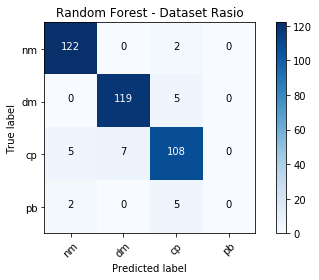

In [6]:
# Compute confusion matrix
rf_matrix = confusion_matrix(y_test, y_RF)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(rf_matrix, classes=class_names,
                      title='Random Forest - Dataset Rasio')

#### Data Cross Validate

In [7]:
skf = StratifiedKFold(n_splits=10)
currentMax = 0

for train_index, test_index in skf.split(x, y):
    X_train_cv, X_test_cv = x[train_index], x[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    
    RFc = RandomForest.fit(X_train_cv, y_train_cv)
    y_RF_cv = RFc.predict(X_test_cv)
    akurasi = accuracy_score(y_test_cv, y_RF_cv)
    
    print ('Akurasi', akurasi)
    target_names = ['class 0', 'class 1', 'class 2', 'class 3']
    print(classification_report(y_test_cv, y_RF_cv, target_names=target_names))
    
    if(currentMax  < akurasi):
        currentMax = akurasi
        y_test_cv_fix = y_test_cv
        y_RF_cv_fix = y_RF_cv
        with open('data/model/rf_cv_model.pkl', 'wb') as rfc:
            pickle.dump(RFc, rfc)

Akurasi 0.7478260869565218
              precision    recall  f1-score   support

     class 0       0.79      1.00      0.88        38
     class 1       1.00      0.47      0.64        38
     class 2       0.61      0.81      0.70        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.75      0.75      0.75       115
   macro avg       0.60      0.57      0.56       115
weighted avg       0.79      0.75      0.73       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9565217391304348
              precision    recall  f1-score   support

     class 0       0.95      0.97      0.96        38
     class 1       0.97      0.97      0.97        38
     class 2       0.95      0.97      0.96        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       115
   macro avg       0.72      0.73      0.72       115
weighted avg       0.94      0.96      0.95       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9565217391304348
              precision    recall  f1-score   support

     class 0       1.00      0.97      0.99        38
     class 1       0.95      1.00      0.97        38
     class 2       0.92      0.95      0.93        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       115
   macro avg       0.72      0.73      0.72       115
weighted avg       0.94      0.96      0.95       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9478260869565217
              precision    recall  f1-score   support

     class 0       0.97      1.00      0.99        38
     class 1       0.93      0.97      0.95        38
     class 2       0.94      0.92      0.93        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.95      0.95      0.95       115
   macro avg       0.71      0.72      0.72       115
weighted avg       0.93      0.95      0.94       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9304347826086956
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00        38
     class 1       0.90      0.95      0.92        38
     class 2       0.89      0.89      0.89        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.93      0.93      0.93       115
   macro avg       0.70      0.71      0.70       115
weighted avg       0.91      0.93      0.92       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9469026548672567
              precision    recall  f1-score   support

     class 0       0.97      0.97      0.97        38
     class 1       0.93      1.00      0.96        37
     class 2       0.94      0.92      0.93        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.95      0.95      0.95       113
   macro avg       0.71      0.72      0.72       113
weighted avg       0.93      0.95      0.94       113



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9642857142857143
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00        37
     class 1       0.95      1.00      0.97        37
     class 2       0.94      0.94      0.94        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       112
   macro avg       0.72      0.74      0.73       112
weighted avg       0.95      0.96      0.96       112



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9553571428571429
              precision    recall  f1-score   support

     class 0       0.95      1.00      0.97        37
     class 1       0.95      0.97      0.96        37
     class 2       0.97      0.94      0.96        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       112
   macro avg       0.72      0.73      0.72       112
weighted avg       0.94      0.96      0.95       112



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9464285714285714
              precision    recall  f1-score   support

     class 0       1.00      0.97      0.99        37
     class 1       0.92      0.97      0.95        37
     class 2       0.92      0.94      0.93        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.95      0.95      0.95       112
   macro avg       0.71      0.72      0.72       112
weighted avg       0.93      0.95      0.94       112



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.8839285714285714
              precision    recall  f1-score   support

     class 0       0.89      0.92      0.91        37
     class 1       0.90      1.00      0.95        37
     class 2       0.85      0.78      0.81        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.88      0.88      0.88       112
   macro avg       0.66      0.67      0.67       112
weighted avg       0.87      0.88      0.87       112



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[37  0  0  0]
 [ 0 37  0  0]
 [ 0  2 34  0]
 [ 0  0  2  0]]


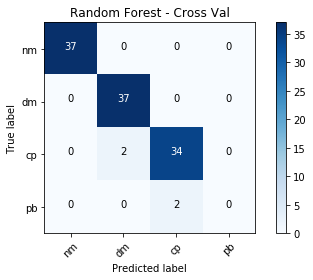

In [8]:
# Compute confusion matrix
rfcv_matrix = confusion_matrix(y_test_cv_fix, y_RF_cv_fix)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(rfcv_matrix, classes=class_names,
                      title='Random Forest - Cross Val')

#### Data Over Sampled - SMOTE

In [9]:
RF_smt = RandomForest.fit(ftr_smt, cls_smt)

y_RF_smt = RF_smt.predict(X_test)
print('Akurasi', accuracy_score(y_test, y_RF_smt))
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_RF_smt, target_names=target_names))
    
with open('data/model/rf_smt_model.pkl', 'wb') as rfs:
    pickle.dump(RF_smt, rfs)

Akurasi 0.9253333333333333
              precision    recall  f1-score   support

     class 0       0.94      0.98      0.96       124
     class 1       0.94      0.94      0.94       124
     class 2       0.90      0.89      0.90       120
     class 3       0.50      0.14      0.22         7

   micro avg       0.93      0.93      0.93       375
   macro avg       0.82      0.74      0.76       375
weighted avg       0.92      0.93      0.92       375



Confusion matrix, without normalization
[[122   0   2   0]
 [  0 117   6   1]
 [  6   7 107   0]
 [  2   0   4   1]]


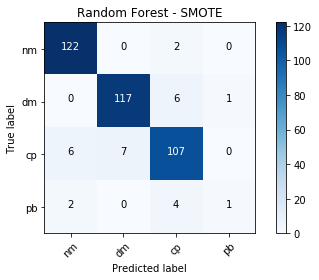

In [10]:
# Compute confusion matrix
rfsmt_matrix = confusion_matrix(y_test, y_RF_smt)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(rfsmt_matrix, classes=class_names,
                      title='Random Forest - SMOTE')

#### Data Over Sampled - Adasyn

In [11]:
RF_ada = RandomForest.fit(ftr_ada, cls_ada)

y_RF_ada = RF_ada.predict(X_test)
print(accuracy_score(y_test, y_RF_ada))
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_RF_ada, target_names=target_names))

with open('data/model/rf_ada_model.pkl', 'wb') as rfa:
    pickle.dump(RF_ada, rfa)

0.9333333333333333
              precision    recall  f1-score   support

     class 0       0.95      0.99      0.97       124
     class 1       0.94      0.95      0.95       124
     class 2       0.91      0.90      0.90       120
     class 3       1.00      0.14      0.25         7

   micro avg       0.93      0.93      0.93       375
   macro avg       0.95      0.75      0.77       375
weighted avg       0.93      0.93      0.93       375



Confusion matrix, without normalization
[[123   0   1   0]
 [  0 118   6   0]
 [  5   7 108   0]
 [  2   0   4   1]]


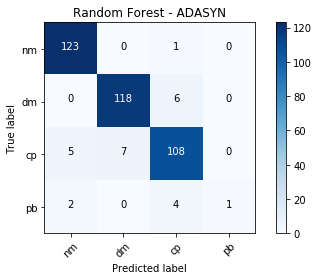

In [12]:
# Compute confusion matrix
rfada_matrix = confusion_matrix(y_test, y_RF_ada)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(rfada_matrix, classes=class_names,
                      title='Random Forest - ADASYN')

# SVM

In [13]:
from sklearn import svm

svm = svm.SVC(kernel='linear', gamma='auto')
svm

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

#### Data splitted 33:67

In [14]:
svm_linear = svm.fit(X_train, y_train)

y_SVM_lin = svm_linear.predict(X_test)
print('Akurasi', accuracy_score(y_test, y_SVM_lin))
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_SVM_lin, target_names=target_names))

#save model
with open('data/model/svm_linear_model.pkl', 'wb') as sl:
    pickle.dump(svm_linear, sl)

Akurasi 0.9306666666666666
              precision    recall  f1-score   support

     class 0       0.94      0.98      0.96       124
     class 1       0.94      0.96      0.95       124
     class 2       0.91      0.89      0.90       120
     class 3       1.00      0.14      0.25         7

   micro avg       0.93      0.93      0.93       375
   macro avg       0.95      0.74      0.77       375
weighted avg       0.93      0.93      0.92       375



Confusion matrix, without normalization
[[122   0   2   0]
 [  0 119   5   0]
 [  6   7 107   0]
 [  2   0   4   1]]


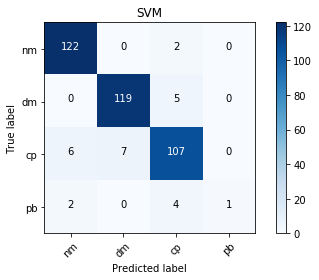

In [15]:
# Compute confusion matrix
svm_matrix = confusion_matrix(y_test, y_SVM_lin)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(svm_matrix, classes=class_names,
                      title='SVM')

#### Data Cross Validate

In [16]:
skf = StratifiedKFold(n_splits=10)
currentMax=0

for train_index, test_index in skf.split(x, y):
    X_train_cv, X_test_cv = x[train_index], x[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    
    svm_cv = svm.fit(X_train_cv, y_train_cv)
    y_SVM_cv = svm_cv.predict(X_test_cv)
    akurasi = accuracy_score(y_test_cv, y_SVM_cv)
    print('Akurasi', akurasi)
    target_names = ['class 0', 'class 1', 'class 2', 'class 3']
    print(classification_report(y_test_cv, y_SVM_cv, target_names=target_names))
    
    if(currentMax  < akurasi):
        currentMax = akurasi
        y_test_cv_fix = y_test_cv
        y_SVM_cv_fix = y_SVM_cv
        with open('data/model/svm_cv_model.pkl', 'wb') as svmc:
            pickle.dump(svm_cv, svmc)

Akurasi 0.7652173913043478
              precision    recall  f1-score   support

     class 0       0.79      1.00      0.88        38
     class 1       0.92      0.58      0.71        38
     class 2       0.65      0.76      0.70        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.77      0.77      0.77       115
   macro avg       0.59      0.58      0.57       115
weighted avg       0.77      0.77      0.75       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9565217391304348
              precision    recall  f1-score   support

     class 0       0.95      1.00      0.97        38
     class 1       0.97      0.97      0.97        38
     class 2       0.95      0.95      0.95        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       115
   macro avg       0.72      0.73      0.72       115
weighted avg       0.94      0.96      0.95       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9565217391304348
              precision    recall  f1-score   support

     class 0       1.00      0.97      0.99        38
     class 1       0.95      1.00      0.97        38
     class 2       0.92      0.95      0.93        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       115
   macro avg       0.72      0.73      0.72       115
weighted avg       0.94      0.96      0.95       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9304347826086956
              precision    recall  f1-score   support

     class 0       0.97      1.00      0.99        38
     class 1       0.88      0.97      0.93        38
     class 2       0.94      0.86      0.90        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.93      0.93      0.93       115
   macro avg       0.70      0.71      0.70       115
weighted avg       0.92      0.93      0.92       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9217391304347826
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00        38
     class 1       0.92      0.89      0.91        38
     class 2       0.85      0.92      0.88        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.92      0.92      0.92       115
   macro avg       0.69      0.70      0.70       115
weighted avg       0.91      0.92      0.91       115



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9557522123893806
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00        38
     class 1       0.93      1.00      0.96        37
     class 2       0.94      0.92      0.93        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       113
   macro avg       0.72      0.73      0.72       113
weighted avg       0.94      0.96      0.95       113



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9553571428571429
              precision    recall  f1-score   support

     class 0       1.00      1.00      1.00        37
     class 1       0.95      0.97      0.96        37
     class 2       0.92      0.94      0.93        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       112
   macro avg       0.72      0.73      0.72       112
weighted avg       0.94      0.96      0.95       112



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9553571428571429
              precision    recall  f1-score   support

     class 0       0.93      1.00      0.96        37
     class 1       0.97      0.97      0.97        37
     class 2       0.97      0.94      0.96        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       112
   macro avg       0.72      0.73      0.72       112
weighted avg       0.94      0.96      0.95       112



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9642857142857143
              precision    recall  f1-score   support

     class 0       1.00      0.97      0.99        37
     class 1       0.97      0.97      0.97        37
     class 2       0.92      1.00      0.96        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.96      0.96      0.96       112
   macro avg       0.72      0.74      0.73       112
weighted avg       0.95      0.96      0.96       112



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Akurasi 0.9196428571428571
              precision    recall  f1-score   support

     class 0       0.92      0.97      0.95        37
     class 1       0.93      1.00      0.96        37
     class 2       0.91      0.83      0.87        36
     class 3       0.00      0.00      0.00         2

   micro avg       0.92      0.92      0.92       112
   macro avg       0.69      0.70      0.69       112
weighted avg       0.90      0.92      0.91       112



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[36  0  1  0]
 [ 0 36  1  0]
 [ 0  0 36  0]
 [ 0  1  1  0]]


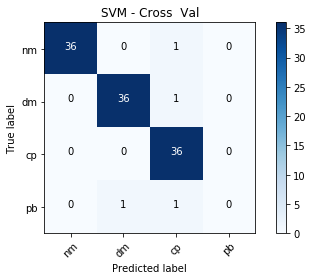

In [17]:
# Compute confusion matrix
svmcv_matrix = confusion_matrix(y_test_cv_fix, y_SVM_cv_fix)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(svmcv_matrix, classes=class_names,
                      title='SVM - Cross  Val')

#### Data Over Sampled - SMOTE

In [18]:
svm_smt = svm.fit(ftr_smt, cls_smt)

y_SVM_smt = svm_smt.predict(X_test)
print('Akurasi', accuracy_score(y_test, y_SVM_smt))
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_SVM_smt, target_names=target_names))

#save model
with open('data/model/svm_smt_model.pkl', 'wb') as ss:
    pickle.dump(svm_smt, ss)

Akurasi 0.9226666666666666
              precision    recall  f1-score   support

     class 0       0.93      0.98      0.96       124
     class 1       0.95      0.98      0.96       124
     class 2       0.94      0.84      0.89       120
     class 3       0.25      0.29      0.27         7

   micro avg       0.92      0.92      0.92       375
   macro avg       0.77      0.77      0.77       375
weighted avg       0.92      0.92      0.92       375



Confusion matrix, without normalization
[[122   0   2   0]
 [  0 121   2   1]
 [  7   7 101   5]
 [  2   0   3   2]]


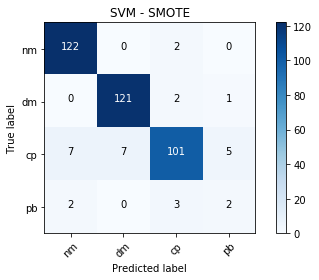

In [19]:
# Compute confusion matrix
svmsmt_matrix = confusion_matrix(y_test, y_SVM_smt)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(svmsmt_matrix, classes=class_names,
                      title='SVM - SMOTE')

#### Data Over Sampled - Adasyn

In [20]:
svm_ada = svm.fit(ftr_ada, cls_ada)

print('SVM Test')
y_SVM_ada = svm_ada.predict(X_test)
print('Akurasi', accuracy_score(y_test, y_SVM_ada))
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_SVM_ada, target_names=target_names))

#save model
with open('data/model/svm_ada_model.pkl', 'wb') as sal:
    pickle.dump(svm_ada, sal)

SVM Test
Akurasi 0.9226666666666666
              precision    recall  f1-score   support

     class 0       0.93      0.98      0.96       124
     class 1       0.95      0.98      0.96       124
     class 2       0.94      0.84      0.89       120
     class 3       0.25      0.29      0.27         7

   micro avg       0.92      0.92      0.92       375
   macro avg       0.77      0.77      0.77       375
weighted avg       0.92      0.92      0.92       375



Confusion matrix, without normalization
[[122   0   2   0]
 [  0 121   2   1]
 [  7   7 101   5]
 [  2   0   3   2]]


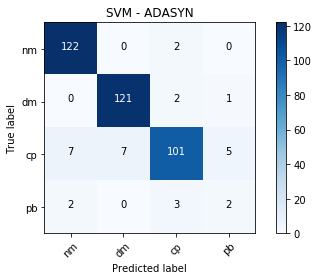

In [21]:
# Compute confusion matrix
svmada_matrix = confusion_matrix(y_test, y_SVM_ada)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(svmada_matrix, classes=class_names,
                      title='SVM - ADASYN')

# Naive Bayes

In [22]:
from sklearn.naive_bayes import MultinomialNB

nb = MultinomialNB(alpha=1)
nb

MultinomialNB(alpha=1, class_prior=None, fit_prior=True)

#### Data splitted 33:67

In [23]:
mnb = nb.fit(X_train, y_train)

y_mnb = mnb.predict(X_test)
print('Akurasi', accuracy_score(y_test, y_mnb))
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_mnb, target_names=target_names))

with open('data/model/nb_model.pkl', 'wb') as nbm:
    pickle.dump(mnb, nbm)

Akurasi 0.9066666666666666
              precision    recall  f1-score   support

     class 0       0.94      0.95      0.95       124
     class 1       0.91      0.95      0.93       124
     class 2       0.86      0.87      0.86       120
     class 3       0.00      0.00      0.00         7

   micro avg       0.91      0.91      0.91       375
   macro avg       0.68      0.69      0.69       375
weighted avg       0.89      0.91      0.90       375



c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[118   0   6   0]
 [  0 118   6   0]
 [  5  11 104   0]
 [  2   0   5   0]]


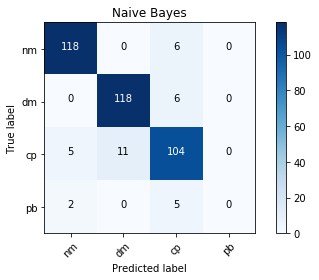

In [24]:
# Compute confusion matrix
nb_matrix = confusion_matrix(y_test, y_mnb)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(nb_matrix, classes=class_names,
                      title='Naive Bayes')

#### Data Cross Validate

In [25]:
skf = StratifiedKFold(n_splits=10)
currentMax=0

for train_index, test_index in skf.split(x, y):
    X_train_cv, X_test_cv = x[train_index], x[test_index]
    y_train_cv, y_test_cv = y[train_index], y[test_index]
    
    nb_cv = nb.fit(X_train_cv, y_train_cv)
    y_nb_cv = nb_cv.predict(X_test_cv)
    akurasi = accuracy_score(y_test_cv, y_nb_cv)
    
    print('Akurasi', akurasi)
    target_names = ['class 0', 'class 1', 'class 2', 'class 3']
    print(classification_report(y_test_cv, y_nb_cv, target_names=target_names))
    
    if(currentMax  < akurasi):
        currentMax = akurasi
        y_test_cv_fix = y_test_cv
        y_nb_cv_fix = y_nb_cv
        with open('data/model/nb_cv_model.pkl', 'wb') as nbc:
            pickle.dump(nb_cv, nbc)

Akurasi 0.8260869565217391
              precision    recall  f1-score   support

     class 0       0.88      0.95      0.91        38
     class 1       0.90      0.71      0.79        38
     class 2       0.73      0.86      0.79        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.83      0.83      0.83       115
   macro avg       0.63      0.63      0.62       115
weighted avg       0.82      0.83      0.82       115

Akurasi 0.9478260869565217
              precision    recall  f1-score   support

     class 0       0.95      0.97      0.96        38
     class 1       0.95      1.00      0.97        38
     class 2       0.94      0.92      0.93        37
     class 3       0.00      0.00      0.00         2

   micro avg       0.95      0.95      0.95       115
   macro avg       0.71      0.72      0.72       115
weighted avg       0.93      0.95      0.94       115

Akurasi 0.9391304347826087
              precision    recall  f1-score   sup

c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
c:\users\purina qa\appdata\local\programs\python\python36\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: Precision a

Confusion matrix, without normalization
[[36  0  1  0]
 [ 0 36  1  0]
 [ 0  1 35  0]
 [ 0  0  2  0]]


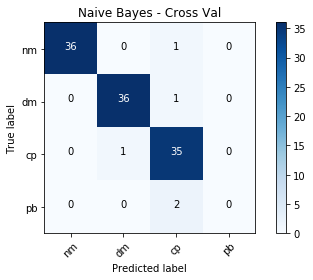

In [26]:
# Compute confusion matrix
nbcv_matrix = confusion_matrix(y_test_cv_fix, y_nb_cv_fix)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(nbcv_matrix, classes=class_names,
                      title='Naive Bayes - Cross Val')

#### Data Over Sampled - SMOTE

In [27]:
mnb_smt = nb.fit(ftr_smt, cls_smt)

print('NB Test')
y_mnb_smt = mnb_smt.predict(X_test)
print(accuracy_score(y_test, y_mnb_smt))
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_mnb_smt, target_names=target_names))

with open('data/model/nb_smt_model.pkl', 'wb') as nbs:
    pickle.dump(mnb_smt, nbs)

NB Test
0.8693333333333333
              precision    recall  f1-score   support

     class 0       0.96      0.94      0.95       124
     class 1       0.91      0.94      0.92       124
     class 2       0.90      0.76      0.82       120
     class 3       0.12      0.43      0.18         7

   micro avg       0.87      0.87      0.87       375
   macro avg       0.72      0.76      0.72       375
weighted avg       0.91      0.87      0.89       375



Confusion matrix, without normalization
[[116   0   2   6]
 [  0 116   5   3]
 [  4  11  91  14]
 [  1   0   3   3]]


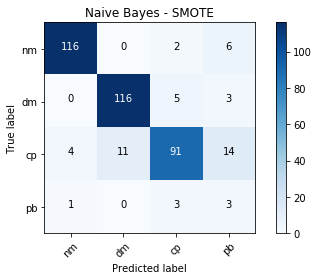

In [28]:
# Compute confusion matrix
nbsmt_matrix = confusion_matrix(y_test, y_mnb_smt)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(nbsmt_matrix, classes=class_names,
                      title='Naive Bayes - SMOTE')

#### Data Over Sampled - Adasyn

In [29]:
mnb_ada = nb.fit(ftr_ada, cls_ada)

print('NB Test')
y_mnb_ada = mnb_ada.predict(X_test)
print(accuracy_score(y_test, y_mnb_ada))
target_names = ['class 0', 'class 1', 'class 2', 'class 3']
print(classification_report(y_test, y_mnb_ada, target_names=target_names))

with open('data/model/nb_ada_model.pkl', 'wb') as nba:
    pickle.dump(mnb_ada, nba)

NB Test
0.8693333333333333
              precision    recall  f1-score   support

     class 0       0.96      0.94      0.95       124
     class 1       0.92      0.94      0.93       124
     class 2       0.90      0.76      0.82       120
     class 3       0.11      0.43      0.18         7

   micro avg       0.87      0.87      0.87       375
   macro avg       0.72      0.76      0.72       375
weighted avg       0.91      0.87      0.89       375



Confusion matrix, without normalization
[[116   0   2   6]
 [  0 116   5   3]
 [  4  10  91  15]
 [  1   0   3   3]]


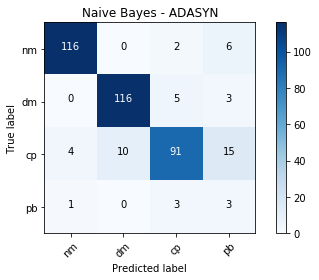

In [30]:
# Compute confusion matrix
nbada_matrix = confusion_matrix(y_test, y_mnb_ada)
np.set_printoptions(precision=2)
plt.figure()
plot_confusion_matrix(nbada_matrix, classes=class_names,
                      title='Naive Bayes - ADASYN')